In [11]:
%load_ext autoreload 
%autoreload 2

%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
from src.acquisition import *
from src.feature_engineering import *
from src.visualization import *

In [13]:
import pandas as pd 
import xgboost as xgb                                                           # gradient boosting algorithm
import optuna                                                                   # hyperparameter optimization
from catboost import CatBoostRegressor, Pool                                    # gradient boosting algorithm
import numpy as np


from sklearn.linear_model import LogisticRegression                             # linear fitting
from sklearn.ensemble import HistGradientBoostingClassifier, IsolationForest    # histogram boosting for NaN, IsolationForest?
from sklearn.cluster import KMeans                                              # K Means technique
from sklearn.neighbors import NearestNeighbors                                  # nearest neighbor 

from sklearn.model_selection import KFold, train_test_split, StratifiedGroupKFold
from sklearn.model_selection import cross_val_score, cross_val_predict  
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 15) 
pd.set_option('display.max_rows', 50)

seed = np.random.seed(578)

## 1. Data acquisition

## 1.2 $\textbf{3DSC}$ Database
$\textit{https://github.com/aimat-lab/3DSC}$ superconductor database 

In [14]:
train_path   = 'data/train.csv'
test_path    = 'data/test.csv'
crystal_path = 'data/Artificial_Crystals_Dataset.csv'
mineral_path = 'data/Mineral_Dataset_Supplementary_Info.csv'

In [15]:
train = acquisition_pipeline(path=train_path,drop_cols='id')
crystal = acquisition_pipeline(path=crystal_path,drop_cols='Unnamed: 0',fill_NA_col='Crystal structure')
mineral = acquisition_pipeline(path=mineral_path,drop_cols='Unnamed: 0')

In [55]:
crystal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Formula                52 non-null     object 
 1   Crystal structure      52 non-null     object 
 2   Hardness (Mohs)        52 non-null     float64
 3   allelectrons_Total     52 non-null     float64
 4   density_Total          52 non-null     float64
 5   allelectrons_Average   52 non-null     float64
 6   val_e_Average          52 non-null     float64
 7   atomicweight_Average   52 non-null     float64
 8   ionenergy_Average      52 non-null     float64
 9   el_neg_chi_Average     52 non-null     float64
 10  R_vdw_element_Average  52 non-null     float64
 11  R_cov_element_Average  52 non-null     float64
 12  zaratio_Average        52 non-null     float64
 13  density_Average        52 non-null     float64
dtypes: float64(12), object(2)
memory usage: 5.8+ KB


In [16]:
view_dataframe_info(train)

DataFrame Information:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB
None
-----------

## 2. Feature Engineering

In [17]:
ignore_features = ['id','Hardness']
features = [f for f in train.columns if f not in ignore_features]

In [18]:
fe_train = feature_engineering_pipeline(train,
        # to_merge=mineral,                                      # merging data with mineral dataset                             
        ignore_outlier_features=ignore_features,                 # ignoring columns for outlier detection   
        outlier_col='Outlier',                                   # outlier column with True/FAlse
        std_features=features,std_method='robust',               # standardization method applied to features
        kmeans_features=features,k_clusters=5,                   # creating new columns with closest cluster + distance to it
        new_column='Crystal structure',to_merge_NN=crystal,      # new column with crystal structure
        encode_columns=['Crystal structure'],encode_method='label',# Categorical LabelEncoder
        )

[INFO.feature_engineering.add_outliers_col]: Found 1232 outliers
[INFO.feature_engineering.create_kmeans_features]: Created 5 cluster cols
[INFO.feature_engineering.merge_with_NN]: Created Crystal structure column with NN values from dataset


In [19]:
fe_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
 12  Outlier                10407 non-null  int64  
 13  cluster                10407 non-null  int32  
 14  dist_to_center_0       10407 non-null  float64
 15  di

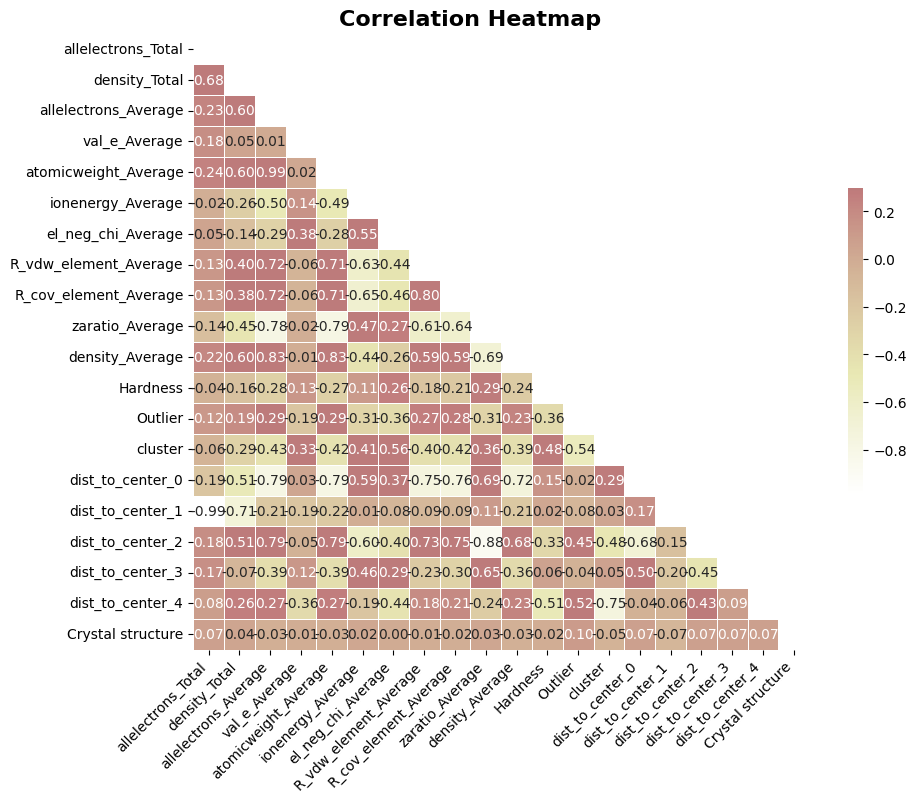

In [20]:
view_upper_corr_matrix(fe_train,"spearman")

In [21]:
view_mutual_info_regression(fe_train,"Hardness")

+-----------------------+--------------------+
|        Feature        | Mutual Information |
+-----------------------+--------------------+
|  atomicweight_Average |       0.495        |
|    zaratio_Average    |       0.492        |
|   ionenergy_Average   |        0.45        |
| R_cov_element_Average |       0.438        |
| R_vdw_element_Average |       0.404        |
|   el_neg_chi_Average  |        0.4         |
|  allelectrons_Average |       0.394        |
|     density_Total     |       0.327        |
|    dist_to_center_2   |       0.302        |
|     val_e_Average     |       0.283        |
|   allelectrons_Total  |       0.274        |
|    dist_to_center_4   |       0.254        |
|    dist_to_center_0   |       0.233        |
|    dist_to_center_1   |       0.225        |
|    density_Average    |       0.212        |
|    dist_to_center_3   |       0.174        |
|        cluster        |       0.159        |
|        Outlier        |       0.068        |
|   Crystal s

## 2.1 Train Test Split

In [22]:
y = fe_train['Hardness'].values
X = fe_train.drop(columns=['Hardness'])

In [23]:
X_train, X_val,y_train,y_val = train_test_split(X,y,test_size=0.1,shuffle=True,random_state=seed)

## 3. Model selection

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
models = {
    'XGB': XGBRegressor(random_state=seed),
    'CAT': CatBoostRegressor(random_state=seed),
    'GB' : GradientBoostingRegressor(random_state=seed),
    'HGB': HistGradientBoostingRegressor(random_state=seed)
}


param_grids = {
    'XGB': {
        'max_depth':                [9],
        'learning_rate':            [0.06],
        'n_estimators':             [169],
        'eval_metric':              ['rmse'],
        'tree_method':              ['exact'],
        'sampling_method':          ['uniform'],
        'subsample':                [0.7841394148733731],
        'colsample_bytree':         [0.95],
        'learning_rate':            [0.04442655333145627],
        'reg_alpha':                [0.003],
        'reg_lambda':               [0.001],
        'gamma':                    [0.022],
        'min_child_weight':         [10],
        'objective':                ["reg:absoluteerror"]

    },

    'CAT': {
        'verbose':                  [False],
        'iterations':               [3000],
        'loss_function':            ['Quantile:alpha=0.5'],
        'depth':                    [7],
        'subsample':                [0.7841394148733731],
        'learning_rate':            [0.04442655333145627],
        'l2_leaf_reg':              [3.523614847869309],
        'leaf_estimation_method':   ['Exact'],
        'boost_from_average':       [True],
    },
    'GB': {
        'alpha':                    [0.45],
        'max_depth':                [8], 
        'subsample':                [0.7841394148733731],
        'n_estimators':             [271], 
        'min_samples_leaf':         [9], 
        'learning_rate':            [0.04442655333145627],
        'min_samples_split':        [15],
        'loss':                     ["absolute_error"],
    },
    'HGB': {
        'max_iter':                 [251],
        'max_depth':                [10], 
        'max_leaf_nodes':           [776],
        'learning_rate':            [0.04442655333145627],
        'min_samples_leaf':         [16], 
        'l2_regularization':        [1.2],
        'loss':                     ["absolute_error"],
    }
}


## 4. Training and Validation

In [25]:
best_models = {}
best_score = float('inf')

In [26]:
from sklearn.model_selection import KFold

for model_name, model in models.items():
    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(
            model,
            param_grid,
            cv=KFold(shuffle=True,random_state=seed),
            scoring='neg_median_absolute_error',
            verbose=False,
            return_train_score=True,
        )

    grid_search.fit(X_train, y_train)
    cv_results = grid_search.cv_results_

    best_models[model_name] = grid_search.best_estimator_

    # pretty-print model configurations
    print("=" * 170)
    for i, params in enumerate(cv_results['params']):
        score = abs(cv_results['mean_test_score'][i])
        print(f"[{model_name}]:\t{score}\t\t{params}\t")

[XGB]:	0.5685319995880127		{'colsample_bytree': 0.95, 'eval_metric': 'rmse', 'gamma': 0.022, 'learning_rate': 0.04442655333145627, 'max_depth': 9, 'min_child_weight': 10, 'n_estimators': 169, 'objective': 'reg:absoluteerror', 'reg_alpha': 0.003, 'reg_lambda': 0.001, 'sampling_method': 'uniform', 'subsample': 0.7841394148733731, 'tree_method': 'exact'}	
[CAT]:	0.558354173971277		{'boost_from_average': True, 'depth': 7, 'iterations': 3000, 'l2_leaf_reg': 3.523614847869309, 'leaf_estimation_method': 'Exact', 'learning_rate': 0.04442655333145627, 'loss_function': 'Quantile:alpha=0.5', 'subsample': 0.7841394148733731, 'verbose': False}	
[GB]:	0.5507723502002458		{'alpha': 0.45, 'learning_rate': 0.04442655333145627, 'loss': 'absolute_error', 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 15, 'n_estimators': 271, 'subsample': 0.7841394148733731}	
[HGB]:	0.5438359875327903		{'l2_regularization': 1.2, 'learning_rate': 0.04442655333145627, 'loss': 'absolute_error', 'max_depth': 10, 

In [27]:
ensemble_clf = VotingRegressor(
    estimators=[
        ('XGB',best_models['XGB']),
        ('CAT',best_models['CAT']),
        ('GB',best_models['GB']),
        ('HGB',best_models['HGB']),
    ],
    # weights=[0.3, 0.7],
    verbose=True
)

## 4.2 Validation

In [65]:
ensemble_clf.fit(X_train,y_train)

[Voting] ...................... (1 of 4) Processing XGB, total=   1.7s
[Voting] ...................... (2 of 4) Processing CAT, total=  24.5s
[Voting] ....................... (3 of 4) Processing GB, total=  33.2s
[Voting] ...................... (4 of 4) Processing HGB, total=   4.7s


VotingRegressor(estimators=[('XGB',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.95, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=0.022,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_r...
                                                       learning_rate=0.04442655333145627,
                                                       loss='absolute_error',
                                                       max_depth=8,
                                                       min_samples_leaf=9,
                                                       min_samples_split=15,
                                                       n_estimators=271,
                                                       subsample=0.7841394148733731)),
                            ('HGB',
                             HistGradientBoostingRegressor(l2_regularization=1.2,
                                                           learning_rate=0.04442655333145627,
                                                           loss='absolute_error',
                                                           max_depth=10,
                                                           max_iter=251,
                                                           max_leaf_nodes=776,
                                                           min_samples_leaf=16))],
                verbose=True)

In [66]:
print("[MedAE]:\t\t", ensemble_clf.score(X_val,y_val))

[MedAE]:		 0.4585708796615162


## 5. Test Preparation

In [74]:
test = acquisition_pipeline(path=test_path)
test_ids = test['id']
test = test.drop(columns='id')

[INFO.acquisition.read_csv_errorless]: Dataframe (6939, 12) ...


In [75]:
test_ids

0       10407
1       10408
2       10409
3       10410
4       10411
        ...  
6934    17341
6935    17342
6936    17343
6937    17344
6938    17345
Name: id, Length: 6939, dtype: int64

In [76]:
fe_test = feature_engineering_pipeline(test,
        ignore_outlier_features=ignore_features,                    # ignoring columns for outlier detection   
        outlier_col='Outlier',                                      # Isolation Forests outlier column with True/FAlse
        std_features=features,std_method='robust',                  # standardization method applied to features
        kmeans_features=features,k_clusters=5,                      # creating new columns with closest cluster + distance to it
        new_column='Crystal structure',to_merge_NN=crystal,         # create Nearest Neighbour Column 
        encode_columns=['Crystal structure'], encode_method='label'
        )

[INFO.feature_engineering.add_outliers_col]:		 Found 795 outliers
[INFO.feature_engineering.create_kmeans_features]:		 Created 5 cluster cols
[INFO.feature_engineering.merge_with_NN]:		 Created Crystal structure column with NearestNeighbor
[INFO.feature_engineering.categoric_encoder]:		 (6939, 19) encoded


In [77]:
test_preds = ensemble_clf.predict(fe_test)

## Kaggle submission

In [78]:
sample_df = pd.read_csv('data/sample_submission.csv')
sample_df['Hardness'] = test_preds 
sample_df['id'] = test_ids 

sample_df.to_csv('data/sample_submission.csv', index=False)